In [2]:
import pandas as pd 
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler, PowerTransformer, OrdinalEncoder
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import pycaret


import warnings
warnings.filterwarnings("ignore")

In [3]:
url = 'marketing_campaign.csv'
df = pd.read_csv(url, delimiter="\t")

In [70]:
# missing data to be found 
missing_data_df = df[df['Income'].isna()]
to_drop_from_df = missing_data_df.index
df_dropped = df.drop(to_drop_from_df, axis=0).reset_index(drop=True)


# Use the indices to filter the original DataFrame
missing_data_df = df.loc[to_drop_from_df]

# Dropping Duplicated values
duplicated_col = df.columns
df.drop_duplicates(subset=duplicated_col.drop("ID").to_list(), inplace=True)


In [38]:
# Dropping of columns with no Std meaning no change in values

def df_cleaning(df):
    for col in df.select_dtypes(include='number'):
        if df[col].std() == 0:
            df.drop([col],axis=1, inplace=True)

            
    # Dropping of impossible ages 
    drop_age_index = df[df['Year_Birth'] <= 1925].index
    df.drop(drop_age_index.tolist(),axis=0, inplace=True)

    # Dropping of ambigous Martial Status 
    df.drop(df[(df['Marital_Status'] ==  'Absurd') | (df['Marital_Status'] == 'YOLO')].index, axis=0, inplace=True)

    # Splitting to Numeric & Categorical 
    df_numeric = df.select_dtypes(include='number')
    df_cat = df.select_dtypes(exclude='number')

    
    df_cat['Marital_Status'].replace('Alone', 'Single', inplace=True)
    df_cat = pd.concat([df_cat, pd.get_dummies(df_cat['Marital_Status'])], axis=1)

    # Eduction categorise allignemnt 
    df_cat['Education'].replace(['2n Cycle', 'Basic'], ['Master', 'Graduation'], inplace=True)

    # Ordinal Encoder 
    encoder = OrdinalEncoder()

    encoer_dict = {cat: i for (i, cat) in enumerate(df_cat['Education'].unique())}
    encoer_dict['PhD'] = 2
    encoer_dict['Master'] = 1

    df_cat['encoded_education'] = df_cat['Education'].replace(encoer_dict)

    day, month, year = [], [], []

    for i in df_cat['Dt_Customer']:
        split_i = i.split('-')
        day.append(int(split_i[0]))
        month.append(int(split_i[1]))
        year.append(int(split_i[2]))
        

    date_dict = {
        'day': day,
        'month': month,
        'year': year
    }
    date_df = pd.DataFrame(date_dict)

    # issue with indexing caused change of shape. 

    date_df.reset_index(drop=True, inplace=True)
    df_cat.reset_index(drop=True, inplace=True)

    df_cat = pd.concat([df_cat,date_df],axis=1)

    df_cat.drop(['Education', 'Marital_Status', 'Dt_Customer'],axis=1, inplace=True)

    df_numeric.drop('ID', axis=1, inplace=True)

    df_numeric.reset_index(drop=True, inplace=True)
    df_cat.reset_index(drop=True, inplace=True)

    df_combined = pd.concat([df_numeric, df_cat], axis=1)

    return df_combined

            

In [6]:
# df_dropped.drop(df_dropped[df_dropped['Year_Birth'] <= 1925].index, axis=0, inplace=True)
# sorted(df_dropped['Income'].tolist(), reverse=True)

# Outlier Income dropping
df_dropped.drop(df_dropped[df_dropped['Income'] == 666666.0].index, axis=0, inplace=True)

In [7]:

# Dropping of impossible ages 
drop_age_index = df_dropped[df_dropped['Year_Birth'] <= 1925].index
df_dropped.drop(drop_age_index.tolist(),axis=0, inplace=True)

# Dropping of ambigous Martial Status 
df_dropped.drop(df_dropped[(df_dropped['Marital_Status'] ==  'Absurd') | (df_dropped['Marital_Status'] == 'YOLO')].index, axis=0, inplace=True)


In [8]:
# Splitting to Numeric & Categorical 
df_numeric = df_dropped.select_dtypes(include='number')
df_cat = df_dropped.select_dtypes(exclude='number')

In [9]:
print(f'Numeric: {df_numeric.shape}\nCat: {df_cat.shape}')

Numeric: (2208, 24)
Cat: (2208, 3)


In [10]:

df_cat['Marital_Status'].replace('Alone', 'Single', inplace=True)
df_cat = pd.concat([df_cat, pd.get_dummies(df_cat['Marital_Status'])], axis=1)
df_cat.shape

(2208, 8)

In [11]:
df_cat['Marital_Status'].value_counts()


Married     857
Together    571
Single      473
Divorced    231
Widow        76
Name: Marital_Status, dtype: int64

In [12]:
# Eduction categorise allignemnt 
df_cat['Education'].replace(['2n Cycle', 'Basic'], ['Master', 'Graduation'], inplace=True)

df_cat.shape

(2208, 8)

In [13]:
# Ordinal Encoder 
encoder = OrdinalEncoder()

encoer_dict = {cat: i for (i, cat) in enumerate(df_cat['Education'].unique())}
encoer_dict['PhD'] = 2
encoer_dict['Master'] = 1

df_cat['encoded_education'] = df_cat['Education'].replace(encoer_dict)
df_cat.shape

(2208, 9)

In [14]:
day, month, year = [], [], []

for i in df_cat['Dt_Customer']:
    split_i = i.split('-')
    day.append(int(split_i[0]))
    month.append(int(split_i[1]))
    year.append(int(split_i[2]))
    

date_dict = {
    'day': day,
    'month': month,
    'year': year
}
date_df = pd.DataFrame(date_dict)
df_cat.shape



(2208, 9)

In [15]:
# issue with indexing caused change of shape. 

date_df.reset_index(drop=True, inplace=True)
df_cat.reset_index(drop=True, inplace=True)

df_cat = pd.concat([df_cat,date_df],axis=1)
df_cat.shape, date_df.shape

((2208, 12), (2208, 3))

In [16]:
df_cat.drop(['Education', 'Marital_Status', 'Dt_Customer'],axis=1, inplace=True)

df_cat.shape

(2208, 9)

In [17]:
## Numeric cleaning

In [18]:
df_numeric.drop('ID', axis=1, inplace=True)

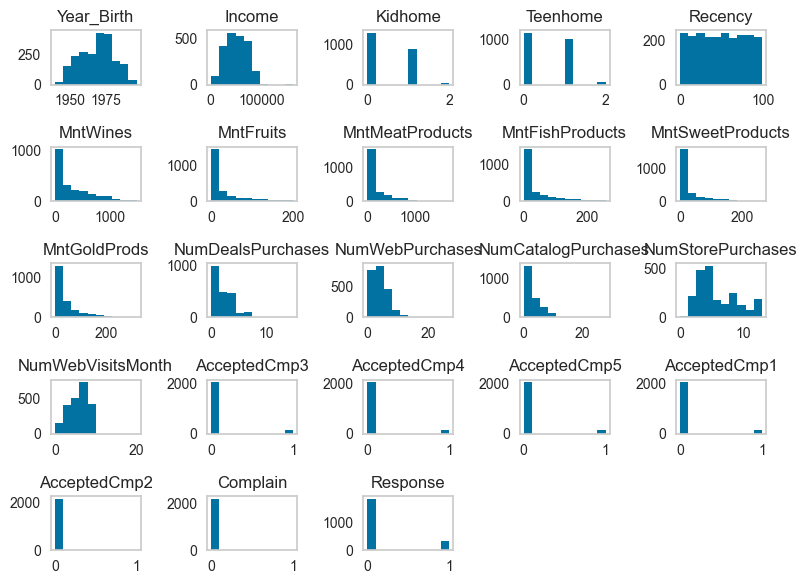

In [19]:
# Consider StdScaler, powertransform
# Scaling to prefoem after split to avoid data leakage 

df_numeric.hist(figsize=(8,6), grid=False)
plt.tight_layout()
plt.show()

In [20]:
# To powertransform 
'''
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
'''

# MinMax Scalling 
'''
 Recency 
 NumWebVisitsMonth
'''


'\n Recency \n NumWebVisitsMonth\n'

In [21]:
df_numeric.reset_index(drop=True, inplace=True)
df_cat.reset_index(drop=True, inplace=True)

df_combined = pd.concat([df_numeric, df_cat], axis=1)



In [22]:
# Train test split 

X = df_combined.drop('Income', axis=1)
y = df_combined[['Income']]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [24]:
print(f'X_train: {X_train.shape} y_train: {y_train.shape}\nX_test: {X_test.shape} y_test: {y_test.shape}')

X_train: (1545, 31) y_train: (1545, 1)
X_test: (663, 31) y_test: (663, 1)


In [25]:
# Scalling did not yield better results

pt = PowerTransformer()

X_train_scaled = pt.fit_transform(X_train)
X_test_scaled = pt.transform(X_test)

type(X_test_scaled)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=[X_train.columns.tolist()])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=[X_test.columns.tolist()])


In [26]:
from sklearn.linear_model import LassoCV


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Instantiate the LassoCV model with cross-validation
lasso_cv = LassoCV(cv=5)  # Adjust cv as needed for the number of folds

# Fit the model to the scaled data
lasso_cv.fit(X_scaled, y)

# Get the optimal value of alpha (regularization parameter)
optimal_alpha = lasso_cv.alpha_

# Get the coefficients of the features
feature_coefficients = lasso_cv.coef_

# Use cross-validation to evaluate the model's performance
mse_scores = cross_val_score(lasso_cv, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-mse_scores)

# Print the optimal alpha, feature coefficients, and evaluation scores
# print("Optimal Alpha:", optimal_alpha)
# print("Feature Coefficients:", feature_coefficients)
# print("Cross-Validation RMSE Scores:", rmse_scores)
# print("Mean RMSE:", np.mean(rmse_scores))


In [27]:
lm = LinearRegression()

model = lm.fit(X, y)
cv_score = cross_val_score(lm, X, y, cv=20, scoring='r2')
y_pred_cv = cross_val_predict(model, X, y, cv=5)

# print("Cross-validation scores:", cv_score)
print("Mean R^2 score:", np.mean(cv_score))


Mean R^2 score: 0.7650061798532113


In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate evaluation metrics
mae = mean_absolute_error(y, y_pred_cv)
mse = mean_squared_error(y, y_pred_cv)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred_cv)

# Print the evaluation metrics
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared Score:", r2)


Mean Absolute Error: 7208.491664303357
Mean Squared Error: 112961606.94318722
Root Mean Squared Error: 10628.339801831104
R-squared Score: 0.7563496781970578


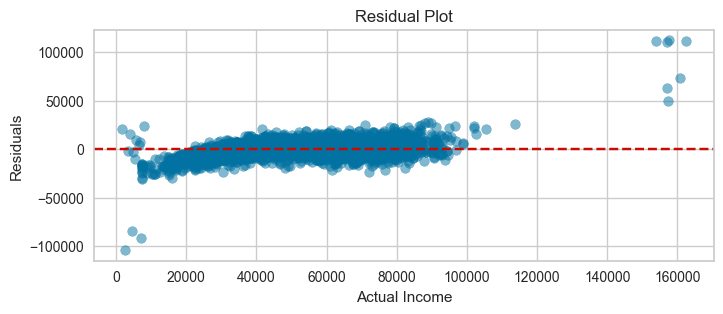

In [29]:
# Calculate residuals
residuals = y - y_pred_cv

# Create a residual plot
plt.figure(figsize=(8, 3))
plt.scatter(y, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Income')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


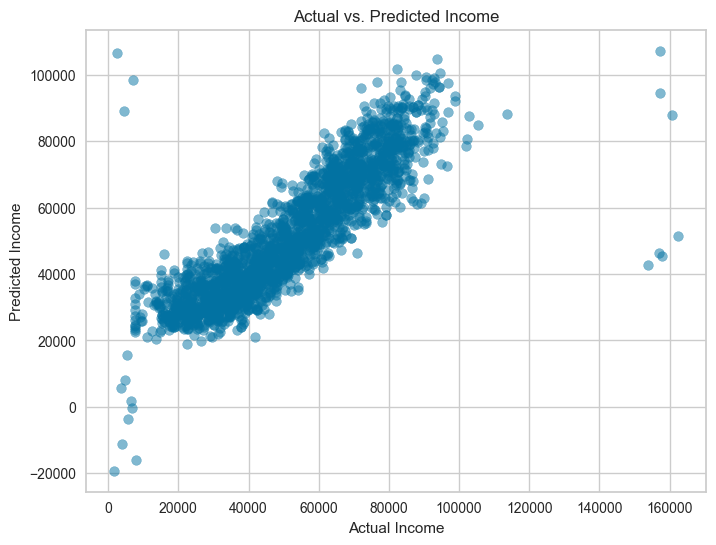

In [30]:

# Create a scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred_cv, alpha=0.5)
plt.xlabel('Actual Income')
plt.ylabel('Predicted Income')
plt.title('Actual vs. Predicted Income')
plt.show()

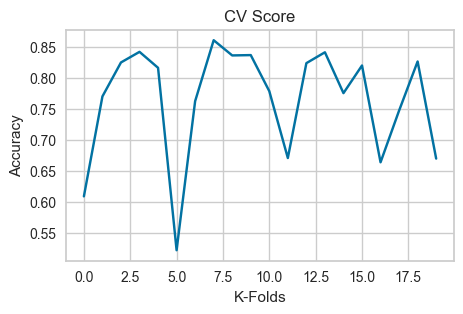

In [31]:
# cv_score = cv_score.tolist()
plt.figure(figsize=(5,3))
plt.title('CV Score')
plt.xlabel('K-Folds')
plt.ylabel('Accuracy')
plt.plot(cv_score)
plt.show()

In [32]:
from pycaret.regression import *

# Assuming X is your features and y is your target variable
# Combine X and y into a DataFrame
data = pd.concat([X, y], axis=1)

# Initialize the setup
setup(data,
       target='Income'
       ) 

# Compare models
best_model = compare_models()

,Description,Value
0,Session id,1684
1,Target,Income
2,Target type,Regression
3,Original data shape,"(2208, 32)"
4,Transformed data shape,"(2208, 32)"
5,Transformed train set shape,"(1545, 32)"
6,Transformed test set shape,"(663, 32)"
7,Numeric features,31
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,5687.2357,85095427.5356,8915.1142,0.8127,0.2422,0.1960,0.1010
gbr,Gradient Boosting Regressor,5845.4535,87771510.3586,8936.3654,0.8059,0.2322,0.1998,0.0460
rf,Random Forest Regressor,5920.7140,91929983.6914,9289.2724,0.7984,0.2486,0.2017,0.1510
et,Extra Trees Regressor,5509.0858,96623799.8106,9294.9294,0.7885,0.2479,0.2010,0.0860
br,Bayesian Ridge,7214.0061,118657226.8510,10552.6164,0.7417,0.2781,0.2358,0.0070
lasso,Lasso Regression,7227.7088,119063618.0030,10561.4854,0.7410,0.2768,0.2355,0.2780
ridge,Ridge Regression,7227.0181,119040661.5154,10560.5393,0.7410,0.2768,0.2355,0.0070
llar,Lasso Least Angle Regression,7227.7080,119063608.1745,10561.4848,0.7410,0.2768,0.2355,0.0070
lr,Linear Regression,7228.5554,119090580.3069,10562.7292,0.7409,0.2768,0.2355,0.5950
en,Elastic Net,7424.4513,121927447.3989,10752.9820,0.7337,0.3037,0.2424,0.0060


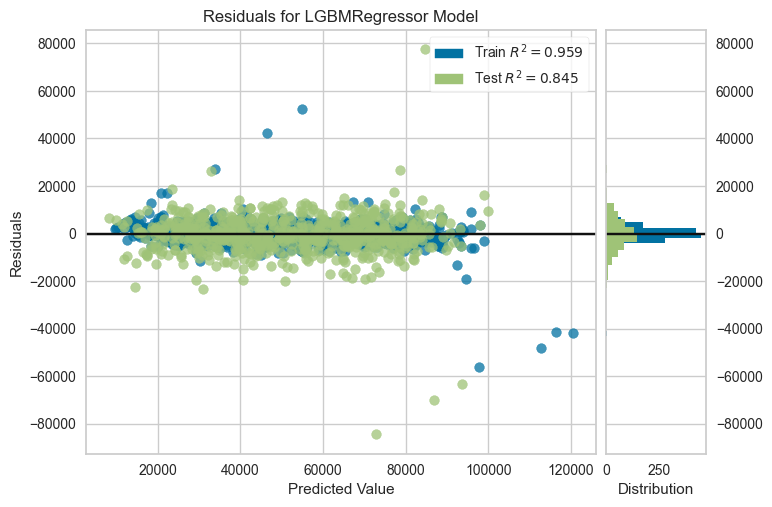

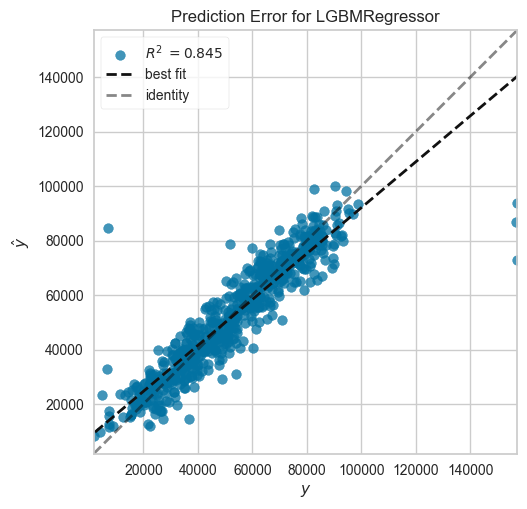

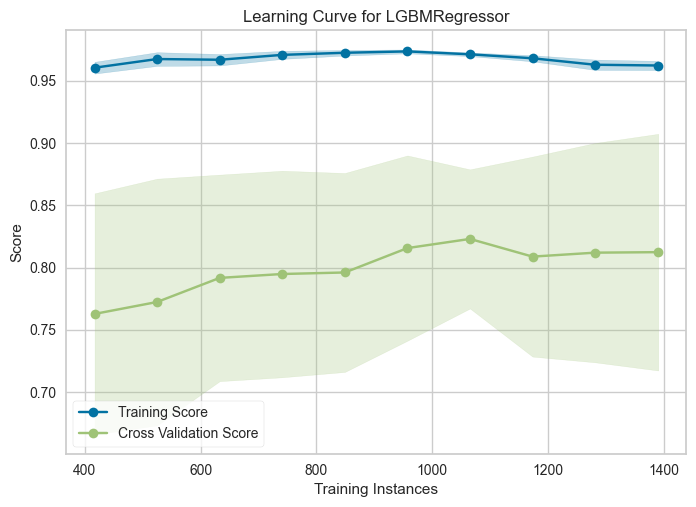

In [34]:
# Plot actual vs predicted values
plot_model(best_model, plot='residuals',)
plot_model(best_model, plot='error')
plot_model(best_model, plot='learning')


In [71]:
df_to_predict = df_cleaning(missing_data_df)

In [97]:
df_to_predict['Divorced'] = 0
df_to_predict['Complain'] = 0
df_to_predict['AcceptedCmp3'] = 0
df_to_predict['AcceptedCmp2'] = 0

In [100]:
predictions = predict_model(best_model, data=df_final_unseen)

In [110]:
predicted_income = predictions['prediction_label'].tolist()

insert_dict = {
    'Income': predicted_income
}

missing_data_df['Income'] = predicted_income

In [132]:

prediction_index = 0
for index, row in df.iterrows():
    if pd.isnull(row['Income']):  
        df.at[index, 'Income'] = predicted_income[prediction_index] 
        prediction_index += 1  


In [139]:
df

df.to_csv('fixed_df_with_income.csv')